In [1]:
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


size = 256
batch_size = 128
epochs = 40
history = {}
def build_model(optimizer): #default initialization: glorot_uniform
    input_shape = (size, size, 3)
    num_filter1 = 64
    num_filter2 = 128
    num_filter3 = 512
    num_classes = 39
    layers = [
            Conv2D(num_filter1, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            Conv2D(num_filter2, (3, 3), padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)), 
            Conv2D(num_filter3, (3, 3),  padding='same', activation='relu'),
            MaxPool2D(pool_size=(2, 2)),
            Flatten(),
            Dense(num_classes, activation='softmax')
    ]
    model = tf.keras.Sequential(layers)
    model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
    )
    return model

In [2]:
optim = {}
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
optim['adam'] = adam


train_path = '../input/traindata/train_aug'
test_path = '../input/val-leaf/val'
gen = ImageDataGenerator(rescale=1./255)
train_generator = gen.flow_from_directory(train_path,     
    target_size = (size, size),
    shuffle=True, 
    batch_size=batch_size
)
valid_generator = gen.flow_from_directory(test_path,     
    target_size = (size, size),
    shuffle=False, 
    batch_size=batch_size
)

Found 53164 images belonging to 39 classes.
Found 9975 images belonging to 39 classes.


In [3]:
def train_model(k, v):
    model = build_model(v)
    model.summary()
    print('This is a model using:', k)
    model_save = ModelCheckpoint('./CNN_official' + k + '.h5',
                                 save_best_only = True, 
                                 save_weights_only = False,
                                 monitor = 'val_loss', 
                                 mode = 'min', verbose = 1)
    milestone = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=epochs,
              steps_per_epoch=train_generator.n//train_generator.batch_size,
              validation_steps = valid_generator.n//valid_generator.batch_size,
              callbacks = [model_save, early_stop, reduce_lr]
              )
    history[k] = milestone
	
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 5, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)

In [4]:
for k, v in optim.items():
    train_model(k, v)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 512)       590336    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 512)       0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0

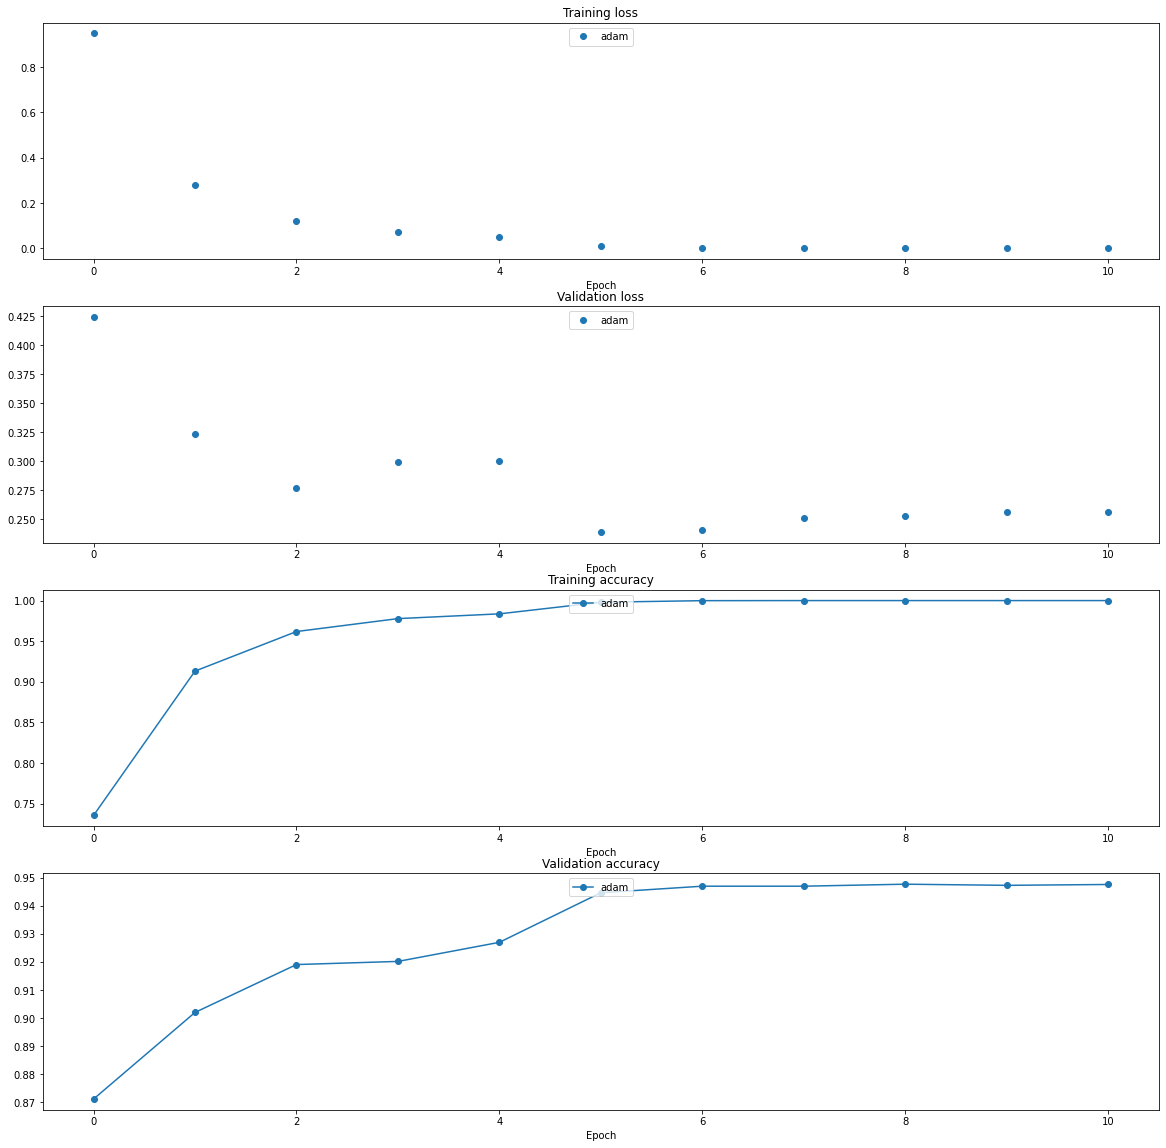

In [5]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)
	
    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()